<img height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px">

<h1>2019 Deep Learning _ HW1</h1>

Polynomial Approximation using Pytorch

- Myeong-Ha Hwang

This file is made by Jaehoon Oh, which is modified based on https://github.com/floydhub/regression

In [0]:
import sys
sys.path.append('/home/users/hmh929/anaconda3/lib/python3.6/site-packages/')
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import tensorboard 
from datetime import datetime


In [0]:
POLY_DEGREE = 4
torch.manual_seed(0)
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5

In [0]:
def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

In [0]:
print('==> The real function you should approximate:\t' + poly_desc(W_target.view(-1), b_target))

==> The real function you should approximate:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


---

In [0]:
def make_features(x):
    """Builds features i.e. a matrix with columns [x^4, x^3, x^2, x^1]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** (POLY_DEGREE+1-i) for i in range(1, POLY_DEGREE+1)], 1)

In [0]:
def f(x):
    """Approximated function."""
    return x.mm(W_target) + b_target[0]

In [0]:
def get_dataset(dataset_size):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(dataset_size)
    x = make_features(random)
    y = f(x)
    dataset = list(zip(x, y))
    
    return dataset

In [0]:
dataset = get_dataset(200) # you can make as many as dataset as you want

---

In [0]:
num_epochs = 500
batch_size = 10
learning_rate = 0.01
criterion = nn.SmoothL1Loss()

In [0]:
dataset_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(W_target.size(0), 1)
        
        #For fixing the initial weights and bias
        self.fc.weight.data.fill_(0.)
        self.fc.bias.data.fill_(0.)
        
    def forward(self, x):
        output = self.fc(x)
        return output

---

---

In [0]:
def fit(model,loader,criterion,learning_rate,num_epochs):
    model.train()
    check_loss = [] ###
    check_loss_append_array = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for i, data in enumerate(loader):
            if torch.cuda.is_available(): # this condition is about gpu availability
                x = data[0].type(torch.FloatTensor).cuda()
                y = data[1].type(torch.FloatTensor).cuda()
            else:
                x = data[0].type(torch.FloatTensor)
                y = data[1].type(torch.FloatTensor)   
                
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            optimizer.zero_grad() # set gradient as 0
            loss.backward() # backpropagation
            optimizer.step() # update parameters (weights & bias)
            
            check_loss.append(loss)
            check_epoch = sum(check_loss) / len(check_loss)
          
            
        check_loss_append_array.append(check_epoch)
    plt.plot(check_loss_append_array) #plotting the loss_graph
    plt.show()
  



            

---

In [0]:
net = Net().cuda() if torch.cuda.is_available() else Net()
print('==> Initial function:\t' + poly_desc(net.fc.weight.data.view(-1), net.fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

==> Initial function:	y = +0.00 x^4 +0.00 x^3 +0.00 x^2 +0.00 x^1 +0.00
==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


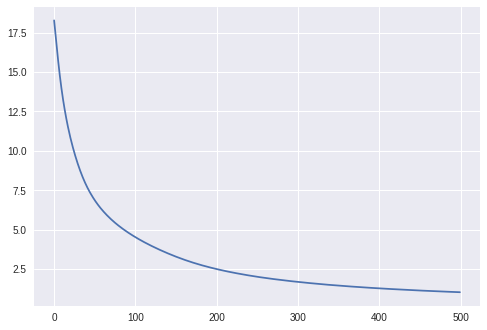

In [0]:
# train
fit(net,dataset_loader,criterion,learning_rate,num_epochs)

In [0]:
print('==> Learned function:\t' + poly_desc(net.fc.weight.data.view(-1), net.fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

==> Learned function:	y = +7.69 x^4 -1.48 x^3 -10.88 x^2 +2.84 x^1 -5.43
==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


In [0]:
learned_weight = net.fc.weight.data.view(-1)
learned_bias = net.fc.bias.data

real_weight = W_target.view(-1)
real_bias = b_target

x_input = np.linspace(-1.5,1.5, 256, endpoint=True)
learned_y_label = learned_weight.numpy()[0]*(x*x*x*x) + learned_weight.numpy()[1]*(x*x*x) + learned_weight.numpy()[2]*(x*x) + learned_weight.numpy()[3]*(x) + learned_bias.item()
real_y_label = (real_weight.numpy()[0]*(x*x*x*x)) + (real_weight.numpy()[1]*(x*x*x)) + (real_weight.numpy()[2]*(x*x)) + (real_weight.numpy()[3]*(x)) + real_bias.item()

plt.plot(x_input,learned_y_label,'b',label="Learned Function")
plt.plot(x_input,real_y_label, 'r', label="Actual Function")
plt.xlabel('x_label')
plt.ylabel('y_label')
plt.legend(loc = 'lower right')

NameError: ignored